# Unit14_Model_Interpretability_Basics | 模型可解釋性基礎

本 Notebook 使用模擬的化工反應器數據，建立多種機器學習模型並進行可解釋性分析。

## 目標
- 理解為什麼化工領域需要可解釋的模型
- 學習基於樹模型的特徵重要性 (Feature Importance) 分析
- 掌握排列重要性 (Permutation Importance) 的原理與應用
- 學習繪製與解讀部分依賴圖 (Partial Dependence Plot, PDP)
- 實作化工案例：解釋反應產率預測模型中各操作變數的影響

## 為什麼化工領域需要可解釋的模型？
1. **安全性驗證**：需要理解模型決策邏輯，確保符合物理化學原理
2. **製程優化**：需要知道哪些操作變數對目標影響最大
3. **故障診斷**：需要追溯異常預測的原因
4. **法規遵循**：部分產業需要提供模型決策依據
5. **知識發現**：從模型中提取新的製程知識

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit14_Model_Interpretability_Basics'
SOURCE_DATA_DIR = 'reactor_data'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit14'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\reactor_data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\figs


In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# IPython 顯示工具
from IPython.display import display

# sklearn套件 - 資料處理與評估
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# sklearn套件 - 模型
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# sklearn套件 - 可解釋性分析
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# 其他工具
import joblib

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

print("✓ 所有套件載入完成")

✓ 所有套件載入完成


---
## 1. 數據生成與準備

我們將模擬一個化工反應器的操作數據，目標是預測**反應產率 (Yield, %)**。

### 特徵變數說明
- **Temperature (°C)**：反應溫度 (150-250°C)
- **Pressure (bar)**：反應壓力 (1-10 bar)
- **Flow_Rate (L/min)**：進料流速 (10-100 L/min)
- **Concentration (%)**：反應物濃度 (10-90%)
- **Residence_Time (min)**：停留時間 (5-60 min)
- **Catalyst_Loading (kg/m³)**：催化劑裝載量 (0.5-5.0 kg/m³)

In [3]:
# 生成模擬化工反應器數據
np.random.seed(SEED)
n_samples = 500

# 生成特徵變數
data = {
    'Temperature': np.random.uniform(150, 250, n_samples),
    'Pressure': np.random.uniform(1, 10, n_samples),
    'Flow_Rate': np.random.uniform(10, 100, n_samples),
    'Concentration': np.random.uniform(10, 90, n_samples),
    'Residence_Time': np.random.uniform(5, 60, n_samples),
    'Catalyst_Loading': np.random.uniform(0.5, 5.0, n_samples)
}

df = pd.DataFrame(data)

# 生成目標變數：反應產率 (Yield, %)
# 設計有意義的關係：
# 1. Temperature: 溫度過高或過低都不利（二次關係）
# 2. Pressure: 壓力越高越好（正相關）
# 3. Flow_Rate: 流速過快反應不完全（負相關）
# 4. Concentration: 濃度適中最好（二次關係）
# 5. Residence_Time: 停留時間越長越好（正相關，但有上限效應）
# 6. Catalyst_Loading: 催化劑越多越好（正相關）

# 計算理想溫度與濃度的偏離度
temp_optimal = 200
conc_optimal = 50

yield_base = 50

yield_value = (
    yield_base
    + 0.15 * df['Pressure']                                    # 壓力正相關
    - 0.08 * df['Flow_Rate']                                   # 流速負相關
    + 0.3 * df['Residence_Time']                               # 停留時間正相關
    + 3.0 * df['Catalyst_Loading']                             # 催化劑正相關
    - 0.02 * (df['Temperature'] - temp_optimal)**2             # 溫度二次關係
    - 0.01 * (df['Concentration'] - conc_optimal)**2           # 濃度二次關係
    + np.random.normal(0, 3, n_samples)                        # 隨機誤差
)

# 限制產率在合理範圍內 (40-95%)
df['Yield'] = np.clip(yield_value, 40, 95)

print(f"✓ 生成 {n_samples} 筆化工反應器模擬數據")
print(f"\n數據集形狀: {df.shape}")
print(f"\n前 5 筆數據:")
display(df.head())

✓ 生成 500 筆化工反應器模擬數據

數據集形狀: (500, 7)

前 5 筆數據:


,Temperature,Pressure,Flow_Rate,Concentration,Residence_Time,Catalyst_Loading,Yield
0,187.454012,7.283455,26.661964,51.526543,19.393813,4.223835,67.457680
1,245.071431,5.824867,58.771085,48.334550,18.583834,3.940375,40.000000
2,223.199394,3.785749,88.565125,12.051365,54.844002,3.080880,46.063975
3,209.865848,8.324155,75.900240,37.299826,18.725041,4.802212,57.543242
4,165.601864,7.162581,82.590503,40.415650,19.957235,1.402135,40.000000


In [4]:
# 數據基本統計分析
print("=" * 60)
print("數據統計摘要")
print("=" * 60)
display(df.describe())

print("\n" + "=" * 60)
print("目標變數 (Yield) 統計")
print("=" * 60)
print(f"平均產率: {df['Yield'].mean():.2f}%")
print(f"標準差: {df['Yield'].std():.2f}%")
print(f"最小值: {df['Yield'].min():.2f}%")
print(f"最大值: {df['Yield'].max():.2f}%")

數據統計摘要


,Temperature,Pressure,Flow_Rate,Concentration,Residence_Time,Catalyst_Loading,Yield
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,199.856171,5.337563,56.580231,49.718119,32.491399,2.772355,48.369301
std,29.868841,2.569441,26.747364,22.960788,15.719504,1.330755,10.030047
min,150.506158,1.041688,10.444598,10.257461,5.086081,0.500052,40.000000
25%,174.127969,3.061893,31.710524,29.285942,19.746170,1.669164,40.000000
50%,201.316375,5.246394,58.576450,50.711307,32.280686,2.758343,42.871590
75%,225.612488,7.537031,79.960938,68.990100,45.881136,3.955579,56.350523
max,249.296480,9.997459,99.947235,89.867801,59.749063,4.990194,83.134324



目標變數 (Yield) 統計
平均產率: 48.37%
標準差: 10.03%
最小值: 40.00%
最大值: 83.13%


---
## 2. 數據分割與預處理

將數據分割為訓練集與測試集，並進行標準化處理。

In [5]:
# 分離特徵與目標
X = df.drop('Yield', axis=1)
y = df['Yield']

# 數據分割 (80% 訓練, 20% 測試)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# 標準化處理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 保留特徵名稱（用於後續可解釋性分析）
feature_names = X.columns.tolist()

print(f"✓ 訓練集大小: {X_train.shape}")
print(f"✓ 測試集大小: {X_test.shape}")
print(f"✓ 特徵數量: {len(feature_names)}")
print(f"\n特徵名稱: {feature_names}")

✓ 訓練集大小: (400, 6)
✓ 測試集大小: (100, 6)
✓ 特徵數量: 6

特徵名稱: ['Temperature', 'Pressure', 'Flow_Rate', 'Concentration', 'Residence_Time', 'Catalyst_Loading']


---
## 3. 訓練多種模型

我們將訓練三種不同類型的模型，以便比較它們的可解釋性方法：
1. **Ridge Regression** (線性模型)
2. **Random Forest** (樹模型)
3. **Gradient Boosting** (集成模型)

In [6]:
# 定義並訓練多種模型
models = {
    'Ridge': Ridge(alpha=1.0, random_state=SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=SEED),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=SEED)
}

# 訓練所有模型並評估
results = {}

print("=" * 60)
print("模型訓練與評估")
print("=" * 60)

for name, model in models.items():
    print(f"\n正在訓練 {name}...")
    
    # 訓練模型
    model.fit(X_train_scaled, y_train)
    
    # 預測
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # 評估指標
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # 交叉驗證
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # 儲存結果
    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std()
    }
    
    print(f"  訓練 R²: {train_r2:.4f}")
    print(f"  測試 R²: {test_r2:.4f}")
    print(f"  測試 MAE: {test_mae:.2f}%")
    print(f"  測試 RMSE: {test_rmse:.2f}%")
    print(f"  交叉驗證 R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n✓ 所有模型訓練完成")

模型訓練與評估

正在訓練 Ridge...
  訓練 R²: 0.2184
  測試 R²: 0.0198
  測試 MAE: 8.08%
  測試 RMSE: 9.62%
  交叉驗證 R²: 0.1728 ± 0.0621

正在訓練 Random Forest...
  訓練 R²: 0.9760
  測試 R²: 0.8413
  測試 MAE: 2.67%
  測試 RMSE: 3.87%
  交叉驗證 R²: 0.8428 ± 0.0259

正在訓練 Gradient Boosting...
  訓練 R²: 0.9987
  測試 R²: 0.8332
  測試 MAE: 2.71%
  測試 RMSE: 3.97%
  交叉驗證 R²: 0.8739 ± 0.0261

✓ 所有模型訓練完成


---
## 4. 特徵重要性分析 (Feature Importance)

### 方法1：基於樹模型的內建特徵重要性

樹模型（如 Random Forest、Gradient Boosting）在建模過程中會計算每個特徵的重要性。重要性的計算基於特徵在分裂節點時對不純度（impurity）的減少貢獻。

**優點**：
- 計算速度快（訓練過程中自動計算）
- 提供全局特徵重要性視角

**限制**：
- 對高基數（high cardinality）特徵有偏好
- 在特徵高度相關時可能不穩定
- 無法用於線性模型

✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\figs\feature_importance_tree_models.png


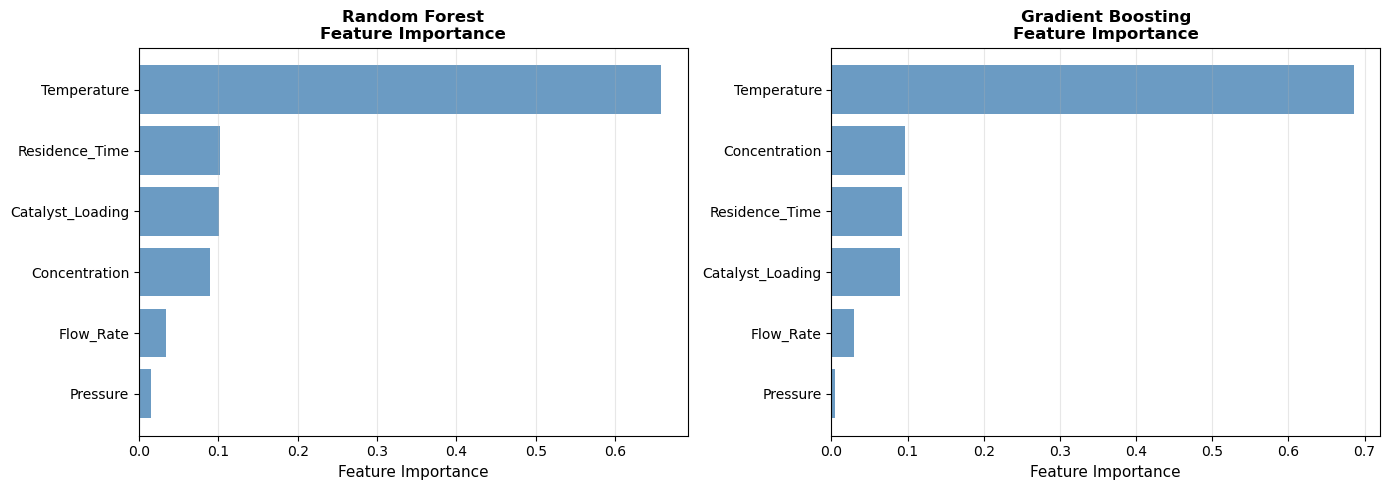


Random Forest - 特徵重要性排序
1. Temperature         : 0.6582
2. Residence_Time      : 0.1027
3. Catalyst_Loading    : 0.1007
4. Concentration       : 0.0895
5. Flow_Rate           : 0.0340
6. Pressure            : 0.0151

Gradient Boosting - 特徵重要性排序
1. Temperature         : 0.6859
2. Concentration       : 0.0967
3. Residence_Time      : 0.0923
4. Catalyst_Loading    : 0.0901
5. Flow_Rate           : 0.0298
6. Pressure            : 0.0052


In [7]:
# 提取樹模型的特徵重要性
tree_models = ['Random Forest', 'Gradient Boosting']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model_name in enumerate(tree_models):
    model = results[model_name]['model']
    importances = model.feature_importances_
    
    # 按重要性排序
    indices = np.argsort(importances)[::-1]
    
    # 繪製特徵重要性
    ax = axes[idx]
    ax.barh(range(len(importances)), importances[indices], color='steelblue', alpha=0.8)
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance', fontsize=11)
    ax.set_title(f'{model_name}\nFeature Importance', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.tight_layout()
fig_path = FIG_DIR / 'feature_importance_tree_models.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ 圖表已儲存: {fig_path}")
plt.show()

# 顯示數值
print("\n" + "=" * 60)
print("Random Forest - 特徵重要性排序")
print("=" * 60)
rf_model = results['Random Forest']['model']
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
for i, idx in enumerate(rf_indices, 1):
    print(f"{i}. {feature_names[idx]:20s}: {rf_importances[idx]:.4f}")

print("\n" + "=" * 60)
print("Gradient Boosting - 特徵重要性排序")
print("=" * 60)
gb_model = results['Gradient Boosting']['model']
gb_importances = gb_model.feature_importances_
gb_indices = np.argsort(gb_importances)[::-1]
for i, idx in enumerate(gb_indices, 1):
    print(f"{i}. {feature_names[idx]:20s}: {gb_importances[idx]:.4f}")

### 解讀特徵重要性結果

從上述結果可以觀察到：
- **Temperature** 是最重要的特徵（重要性超過 0.65），因為溫度的二次關係對產率影響極大
- **Residence_Time**、**Catalyst_Loading** 和 **Concentration** 的重要性相近（約 0.09-0.10）
- **Flow_Rate** 和 **Pressure** 的重要性相對較低
- Random Forest 和 Gradient Boosting 的重要性排序高度一致

---
## 5. 排列重要性分析 (Permutation Importance)

### 方法2：模型無關的排列重要性

Permutation Importance 是一種**模型無關（model-agnostic）**的方法，適用於任何模型（包括線性模型）。

**原理**：
1. 計算模型在測試集上的基準性能
2. 隨機打亂某個特徵的值
3. 重新計算性能，觀察性能下降程度
4. 性能下降越多，表示該特徵越重要

**優點**：
- 可用於任何模型（包括 Ridge、Neural Networks 等）
- 基於模型實際預測性能
- 不受特徵相關性影響較小

**限制**：
- 計算成本較高（需要多次重新預測）
- 對測試集的選擇較敏感

In [8]:
# 計算所有模型的 Permutation Importance
perm_importance_results = {}

print("=" * 60)
print("計算 Permutation Importance")
print("=" * 60)

for name in models.keys():
    print(f"\n正在計算 {name} 的 Permutation Importance...")
    model = results[name]['model']
    
    # 計算排列重要性（使用 R² 作為評分指標）
    perm_importance = permutation_importance(
        model, X_test_scaled, y_test,
        n_repeats=10,
        random_state=SEED,
        scoring='r2'
    )
    
    perm_importance_results[name] = {
        'importances_mean': perm_importance.importances_mean,
        'importances_std': perm_importance.importances_std
    }
    
    print(f"  完成！")

print("\n✓ 所有模型的 Permutation Importance 計算完成")

計算 Permutation Importance

正在計算 Ridge 的 Permutation Importance...
  完成！

正在計算 Random Forest 的 Permutation Importance...
  完成！

正在計算 Gradient Boosting 的 Permutation Importance...
  完成！

✓ 所有模型的 Permutation Importance 計算完成


✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\figs\permutation_importance_all_models.png


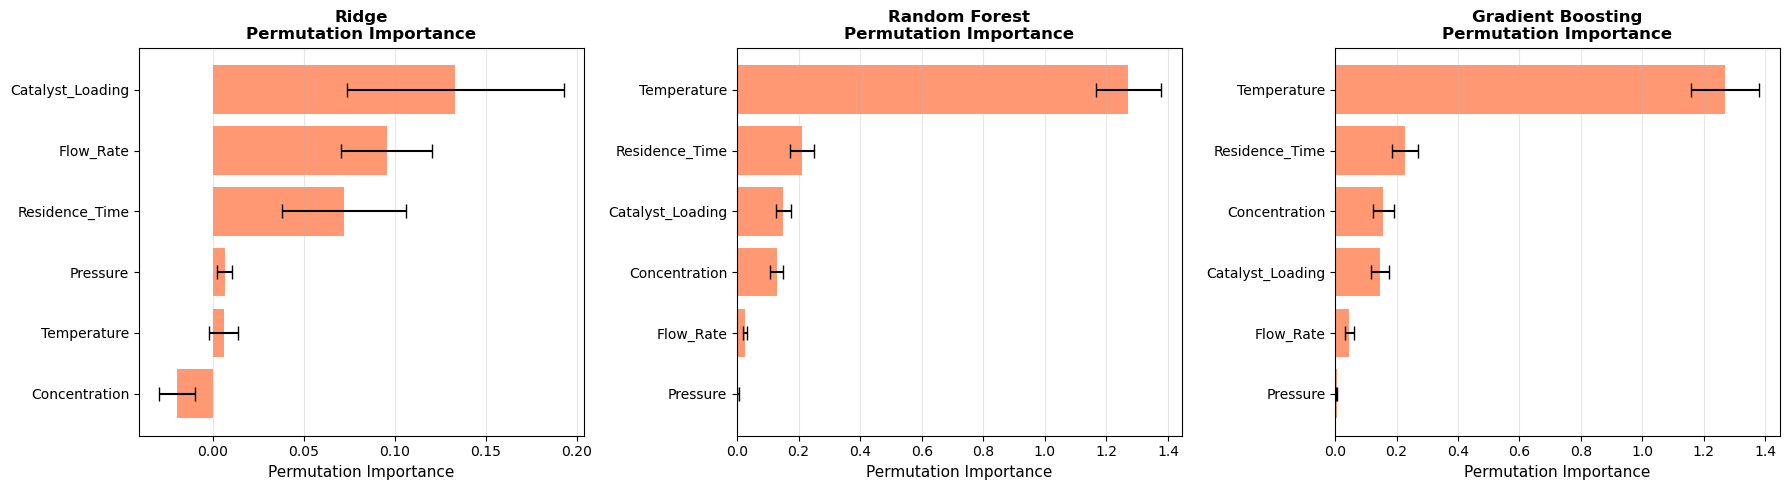


Ridge - Permutation Importance 排序
1. Catalyst_Loading    : 0.1332 ± 0.0595
2. Flow_Rate           : 0.0957 ± 0.0250
3. Residence_Time      : 0.0721 ± 0.0338
4. Pressure            : 0.0066 ± 0.0043
5. Temperature         : 0.0060 ± 0.0078
6. Concentration       : -0.0195 ± 0.0098

Random Forest - Permutation Importance 排序
1. Temperature         : 1.2708 ± 0.1055
2. Residence_Time      : 0.2099 ± 0.0390
3. Catalyst_Loading    : 0.1506 ± 0.0236
4. Concentration       : 0.1283 ± 0.0219
5. Flow_Rate           : 0.0252 ± 0.0058
6. Pressure            : 0.0025 ± 0.0024

Gradient Boosting - Permutation Importance 排序
1. Temperature         : 1.2697 ± 0.1101
2. Residence_Time      : 0.2271 ± 0.0430
3. Concentration       : 0.1575 ± 0.0357
4. Catalyst_Loading    : 0.1466 ± 0.0292
5. Flow_Rate           : 0.0461 ± 0.0146
6. Pressure            : 0.0051 ± 0.0026


In [9]:
# 視覺化 Permutation Importance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, name in enumerate(models.keys()):
    importances_mean = perm_importance_results[name]['importances_mean']
    importances_std = perm_importance_results[name]['importances_std']
    
    # 按重要性排序
    indices = np.argsort(importances_mean)[::-1]
    
    # 繪製排列重要性
    ax = axes[idx]
    ax.barh(range(len(importances_mean)), importances_mean[indices], 
            xerr=importances_std[indices], color='coral', alpha=0.8, capsize=5)
    ax.set_yticks(range(len(importances_mean)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Permutation Importance', fontsize=11)
    ax.set_title(f'{name}\nPermutation Importance', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.tight_layout()
fig_path = FIG_DIR / 'permutation_importance_all_models.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ 圖表已儲存: {fig_path}")
plt.show()

# 顯示數值
for name in models.keys():
    print("\n" + "=" * 60)
    print(f"{name} - Permutation Importance 排序")
    print("=" * 60)
    importances_mean = perm_importance_results[name]['importances_mean']
    importances_std = perm_importance_results[name]['importances_std']
    indices = np.argsort(importances_mean)[::-1]
    
    for i, idx in enumerate(indices, 1):
        print(f"{i}. {feature_names[idx]:20s}: {importances_mean[idx]:.4f} ± {importances_std[idx]:.4f}")

### 解讀 Permutation Importance 結果

**關鍵觀察**：
1. **跨模型一致性**：Random Forest 和 Gradient Boosting 的 Permutation Importance 排序高度一致
2. **最重要特徵**：**Temperature** 是最關鍵的變數（重要性超過 1.2），其次是 Residence_Time、Catalyst_Loading、Concentration
3. **線性模型差異**：Ridge 模型的重要性排序與非線性模型不同，這是因為 Ridge 無法捕捉二次關係
4. **誤差棒（error bar）**：顯示重複排列的穩定性，誤差越小表示重要性越穩定

---
## 6. 部分依賴圖分析 (Partial Dependence Plot, PDP)

### 方法3：部分依賴圖

Partial Dependence Plot (PDP) 顯示**某個特徵如何影響模型預測**，同時將其他特徵邊緣化（平均化）。

**原理**：
1. 固定某個特徵在不同值
2. 保持其他特徵不變（或平均）
3. 觀察模型預測如何隨該特徵變化

**優點**：
- 直觀展示特徵與預測的關係（線性、非線性、單調等）
- 可以檢測交互作用（2D PDP）
- 模型無關

**限制**：
- 假設特徵獨立（可能不符合實際）
- 高維數據中難以展示所有特徵

正在生成 Random Forest 模型的 Partial Dependence Plot...
✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\figs\partial_dependence_plot_all_features.png


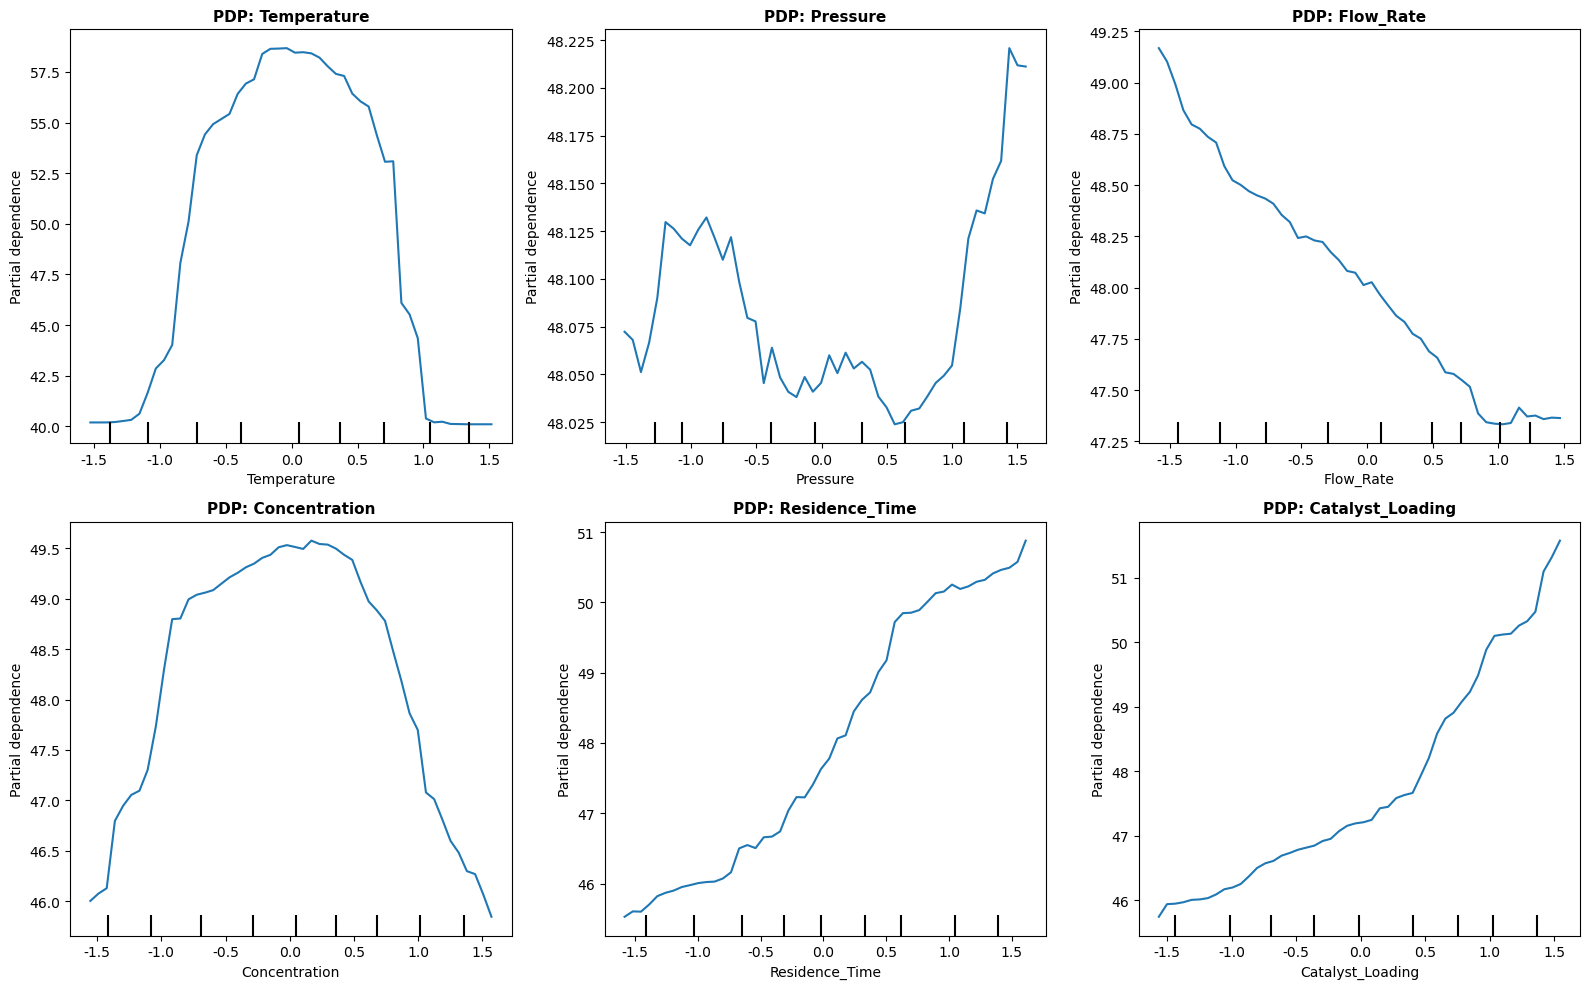

In [10]:
# 繪製 Random Forest 模型的部分依賴圖（所有特徵）
print("正在生成 Random Forest 模型的 Partial Dependence Plot...")

model = results['Random Forest']['model']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# 為每個特徵繪製 PDP
for idx, feature_idx in enumerate(range(len(feature_names))):
    pdp_display = PartialDependenceDisplay.from_estimator(
        model, 
        X_train_scaled, 
        features=[feature_idx],
        feature_names=feature_names,
        ax=axes[idx],
        grid_resolution=50
    )
    axes[idx].set_title(f'PDP: {feature_names[feature_idx]}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(feature_names[feature_idx], fontsize=10)
    axes[idx].set_ylabel('Partial Dependence', fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
fig_path = FIG_DIR / 'partial_dependence_plot_all_features.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ 圖表已儲存: {fig_path}")
plt.show()


正在生成 2D Partial Dependence Plot（探索特徵交互）...
✓ 圖表已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Interpretability_Basics\figs\partial_dependence_plot_2d_interaction.png


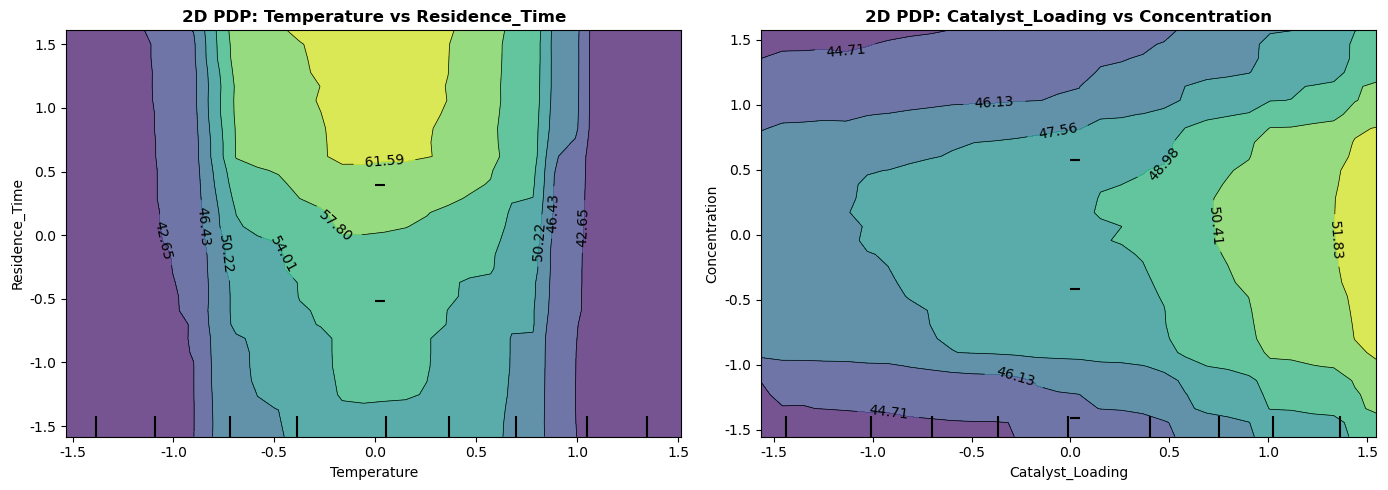

In [11]:
# 繪製 2D Partial Dependence Plot（探索特徵交互作用）
print("\n正在生成 2D Partial Dependence Plot（探索特徵交互）...")

# 選擇重要性最高的兩對特徵
feature_pairs = [
    ('Temperature', 'Residence_Time'),
    ('Catalyst_Loading', 'Concentration')
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (feature1, feature2) in enumerate(feature_pairs):
    feature1_idx = feature_names.index(feature1)
    feature2_idx = feature_names.index(feature2)
    
    pdp_display = PartialDependenceDisplay.from_estimator(
        model,
        X_train_scaled,
        features=[(feature1_idx, feature2_idx)],
        feature_names=feature_names,
        ax=axes[idx],
        grid_resolution=30
    )
    axes[idx].set_title(f'2D PDP: {feature1} vs {feature2}', fontsize=12, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'partial_dependence_plot_2d_interaction.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✓ 圖表已儲存: {fig_path}")
plt.show()

### 解讀 Partial Dependence Plot 結果

**1D PDP 關鍵觀察**：
- **Temperature**：顯示二次關係，在 200°C 附近達到最佳產率（符合設計）
- **Concentration**：同樣顯示二次關係，在 50% 附近最佳
- **Residence_Time**：正相關但逐漸飽和（邊際效益遞減）
- **Catalyst_Loading**：明顯正相關，催化劑越多產率越高
- **Pressure**：正相關，但影響相對較平緩
- **Flow_Rate**：負相關，流速過快導致反應不完全

**2D PDP 交互作用觀察**：
- **Temperature × Residence_Time**：在高溫且長停留時間時產率最高
- **Catalyst_Loading × Concentration**：兩者都處於高值時產率最佳

**化工意義**：
這些結果與化工原理一致，驗證了模型的合理性和可解釋性。

---
## 7. 可解釋性方法綜合比較

比較三種可解釋性方法的特點與適用場景。

In [12]:
# 建立可解釋性方法比較表
comparison_data = {
    '方法': ['Feature Importance', 'Permutation Importance', 'Partial Dependence Plot'],
    '模型限制': ['僅樹模型', '模型無關', '模型無關'],
    '計算成本': ['低（訓練時計算）', '中（需重複預測）', '中（需掃描特徵空間）'],
    '全局/局部': ['全局', '全局', '全局'],
    '特徵關係': ['重要性排序', '重要性排序', '特徵影響曲線'],
    '交互作用': ['否', '否', '是（2D PDP）'],
    '穩定性': ['中（對特徵相關性敏感）', '高', '高'],
    '化工應用': ['快速篩選關鍵變數', '驗證模型穩健性', '理解操作變數影響']
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("可解釋性方法綜合比較")
print("=" * 80)
display(comparison_df)

可解釋性方法綜合比較


,方法,模型限制,計算成本,全局/局部,特徵關係,交互作用,穩定性,化工應用
0,Feature Importance,僅樹模型,低（訓練時計算）,全局,重要性排序,否,中（對特徵相關性敏感）,快速篩選關鍵變數
1,Permutation Importance,模型無關,中（需重複預測）,全局,重要性排序,否,高,驗證模型穩健性
2,Partial Dependence Plot,模型無關,中（需掃描特徵空間）,全局,特徵影響曲線,是（2D PDP）,高,理解操作變數影響


---
## 8. 化工領域應用建議

### 實務應用策略

**階段1：初步探索（Feature Importance）**
- 使用樹模型的內建特徵重要性快速識別關鍵變數
- 適合大規模特徵篩選

**階段2：驗證穩健性（Permutation Importance）**
- 對不同模型計算 Permutation Importance
- 確保重要性結果的跨模型一致性
- 檢測過擬合風險

**階段3：深入理解（Partial Dependence Plot）**
- 繪製 PDP 理解操作變數的影響方向
- 識別最佳操作區間（如溫度、壓力）
- 檢測特徵交互作用

**階段4：製程優化決策**
- 基於可解釋性分析調整操作參數
- 設計實驗驗證模型預測
- 建立可解釋的製程知識庫

### 化工案例應用場景

1. **反應器優化**：識別影響產率的關鍵操作變數
2. **能耗分析**：理解各參數對能耗的影響
3. **品質控制**：找出影響產品品質的主要因素
4. **故障診斷**：追溯異常預測的原因
5. **知識發現**：從模型中提取新的製程規律

---
## 9. 總結與學習要點

### 本 Notebook 學習重點

✓ **理解可解釋性的重要性**
- 化工領域需要理解模型決策邏輯，確保符合物理化學原理
- 可解釋性有助於製程優化、故障診斷、知識發現

✓ **掌握三種核心方法**
1. **Feature Importance**：樹模型內建，快速識別關鍵特徵
2. **Permutation Importance**：模型無關，穩健驗證特徵重要性
3. **Partial Dependence Plot**：視覺化特徵影響，理解非線性關係

✓ **方法選擇策略**
- 快速篩選 → Feature Importance
- 跨模型驗證 → Permutation Importance  
- 深入理解 → Partial Dependence Plot
- 綜合使用可獲得最全面的模型解釋

✓ **化工應用實踐**
- 模型可解釋性分析應與化工知識結合
- 使用可解釋性結果指導製程優化
- 建立可解釋的 AI 決策系統

### 延伸學習方向

1. **SHAP (SHapley Additive exPlanations)**：更先進的模型解釋方法
2. **LIME (Local Interpretable Model-agnostic Explanations)**：局部可解釋性
3. **Individual Conditional Expectation (ICE) Plots**：個體條件期望圖
4. **Accumulated Local Effects (ALE)**：累積局部效應
5. **模型診斷與驗證**：結合可解釋性進行模型驗證

---

## ✓ 完成！

恭喜完成 Unit14 模型可解釋性基礎學習！

你已經掌握了機器學習模型可解釋性的核心方法，可以開始應用到實際化工問題中。